# Using the `autocuts` (`autocuts_noise`)  and `IterCut` Algorithms
_____
This is a demo to show how to use the `autocuts_noise` and the `IterCut` algorithms. There are 3  different types of `autocuts`, each with different selection algorithm:
 * `autocuts_noise`  (or `autocuts`): select good noise traces 
 * `autocuts_didv` (or `autocuts(.., is_didv=True`): select good dIdV traces 
 * `autocuts_template`: select good triggered traces for template generation 

These `autocuts` functions act as a black box (the user cannot see what is going on under the hood), however 
a diagnostics data frame with the calculated variables can be used to fine tune the cuts. The `IterCut` object allows the user to understand each cut being applied to data. 

First, let's import our functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qetpy import autocuts_noise, calc_psd, IterCut
from qetpy.utils import make_template

# ensure that the notebook is repeatable by using the same random seed
np.random.seed(1)

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/site-packages/pytz/__init__.py:499: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/share/zoneinfo/zone.tab' mode='r' encoding='UTF-8'>
  for l in o

Now, let's load the data.

In [2]:
pathtodata = "test_autocuts_data.npy"
traces = np.load(pathtodata)
fs = 625e3

Let's look at the PSD before the cuts, to get a sense of the change.

In [3]:
f, psd = calc_psd(traces, fs=fs, folded_over=True)

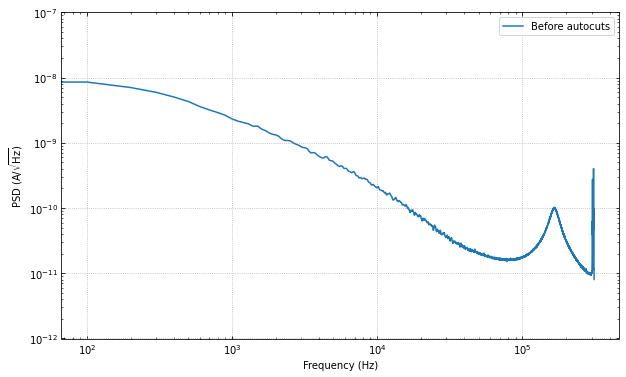

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(f, np.sqrt(psd), label="Before autocuts")
ax.set_ylim([1e-12,1e-7])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'PSD (A/$\sqrt{\mathrm{Hz}}$)')
ax.legend(loc="upper right")
ax.grid(linestyle='dotted')
ax.tick_params(which='both',direction='in',right=True,top=True)

## Using `autocuts_noise`

In [5]:
help(autocuts_noise)

Help on function autocuts_noise in module qetpy.cut._cut:

autocuts_noise(traces, fs=1250000.0, template=[1, 1e-05, 0.0001], psd=None, outlieralgo='sigma_clip', sigma=2, cuts_dict=None, niter=2, lgc_plot=False, nplot=10, lgc_diagnostics=False, verbose=False, **kwargs)
    Function to automatically cut out bad traces from noise data 
    based on the optimum filter amplitude, slope, baseline, 
    and chi^2 of the traces.
    
    Parameters
    ----------    
    traces : ndarray
        2-dimensional array of traces to do cuts on
    fs : float, optional
        Sample rate that the data was taken at (default: 1.25e6)
    template : array-like, optional
        Pulse template numpy array (template length should match  trace length)
        or functional form parameter list:
           2-pole: [A, tau_r, tau_f, (optional) t0] (default)
           3-pole: [A, B, tau_r, tau_f1, tau_f2, (optional) t0] 
           4-pole: [A, B, C, tau_r, tau_f1, tau_f2, tau_f3, (optional) t0] 
           

### Apply autocuts_noise

In [6]:
cut = autocuts_noise(
    traces,
    fs=fs,
)
print(f"The cut efficiency is {100*np.sum(cut)/len(traces):.3f}%")

The cut efficiency is 25.600%


Let's compare the PSD after the cuts, we should see the noise go down by a fair amount.

In [7]:
psd_cut = calc_psd(traces[cut], fs=fs, folded_over=True)[1]

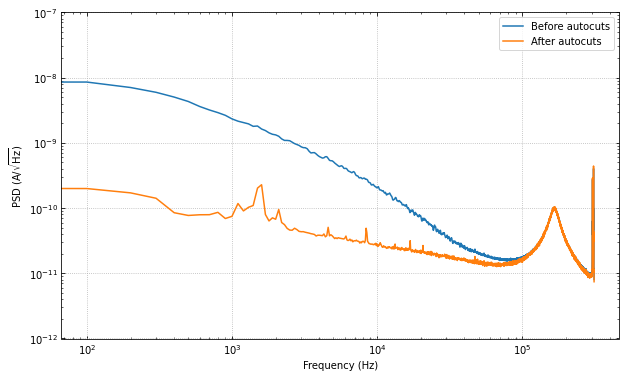

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(f, np.sqrt(psd), label="Before autocuts")
ax.loglog(f, np.sqrt(psd_cut), label="After autocuts")
ax.set_ylim([1e-12,1e-7])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'PSD (A/$\sqrt{\mathrm{Hz}}$)')
ax.legend(loc="upper right")
ax.grid(linestyle='dotted')
ax.tick_params(which='both',direction='in',right=True,top=True)

The change is huge! Which makes sense, as we have removed many of the pulses, muon tails, etc. Please note that there may still be "bad" traces in the data, as the autocuts function is not perfect. There may be more cuts that one would like to do that are more specific to the dataset.

### Cut parameters

The default is to define lower and upper bound with astropy's "sigma_clip". However, a dictionary can be provided with different definition for each cut:

Available cut definition parameters: 

 * "sigma" (used for both lower/upper bounds)
 * "sigma_lower" ("sigma_clip" only): lower bound determined by nb of stds
 * "sigma_upper" ("sigma_clip" only): upper bound determined by nb of stds 
 * "percent_lower": lower bound determined by percent events kept above it 
 * "percent_upper": upper bound determined by percent events kept below it
 * "val_lower": lower bound cut value (events above are kept)
 * "val_upper": upper bound cut value (events below are kept)
     
Example: cuts_dict = {'minmax': {'percent_upper': 50}}  

In [9]:
cuts_dict = {'minmax': {'percent_upper': 50},
             'baseline': {'sigma_lower': 4, 'sigma_upper':1.5}
            }

cut = autocuts_noise(
    traces,
    fs=fs,
    cuts_dict=cuts_dict,
)

print(f"The cut efficiency is {100*np.sum(cut)/len(traces):.3f}%")

The cut efficiency is 17.200%


### Diagnostics and/or traces display

Let's redo autocuts_noise but with diagnotics and display traces

List of cuts (applied sequentially):
['minmax', 'baseline', 'slope', 'ofamps', 'ofchi2']


,minmax,minmax_cut,baseline,baseline_cut,slope,slope_cut,ofamps,ofamps_cut,ofchi2,ofchi2_cut
0,3.143393e-08,True,0.000002,False,NaN,False,NaN,False,NaN,False
1,1.494364e-07,False,NaN,False,NaN,False,NaN,False,NaN,False
2,4.504698e-08,True,0.000002,True,-1.336800e-06,False,NaN,False,NaN,False
3,5.271592e-08,True,0.000002,True,1.462248e-06,False,NaN,False,NaN,False
4,6.804289e-08,False,NaN,False,NaN,False,NaN,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...
995,3.044821e-08,True,0.000002,True,3.398662e-07,True,-1.333200e-08,True,6211.657677,True
996,3.431933e-08,True,0.000002,True,-1.064464e-06,False,NaN,False,NaN,False
997,7.520962e-08,False,NaN,False,NaN,False,NaN,False,NaN,False
998,2.961921e-06,False,NaN,False,NaN,False,NaN,False,NaN,False


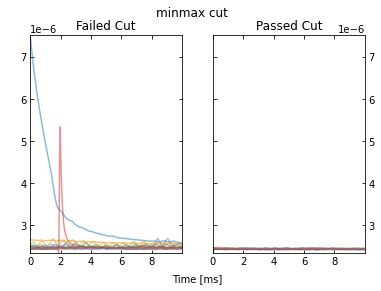

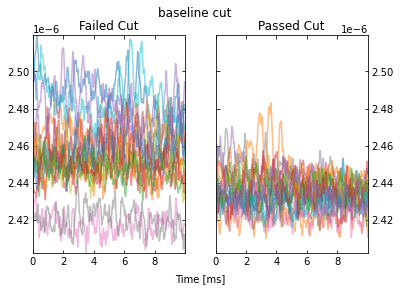

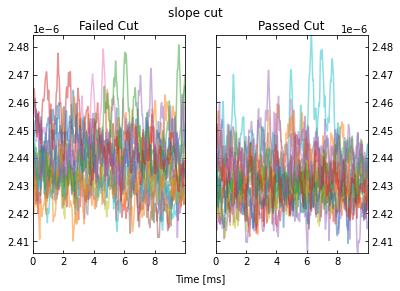

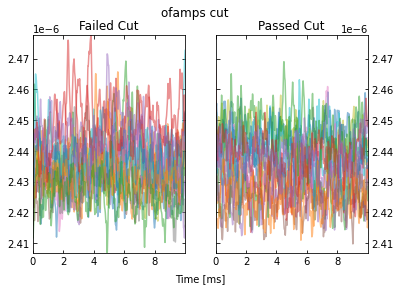

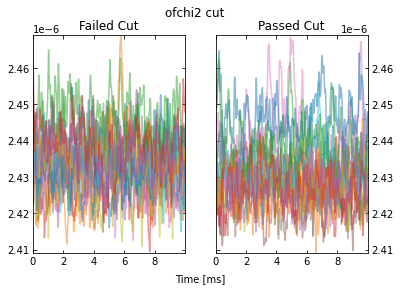

In [10]:
cut, diags = autocuts_noise(
    traces,
    fs=fs,
    lgc_plot=True,
    nplot=15,
    lgc_diagnostics=True,
)

# list of cuts applied (cuts done sequentially with order as in list)
print('List of cuts (applied sequentially):')
print(diags['cuts'])

# parameters (and associated cuts) are saved in a pandas data frame
diags['df']

Let's look for example at the baseline (cuts done after a loose minmax cut so some events missing)

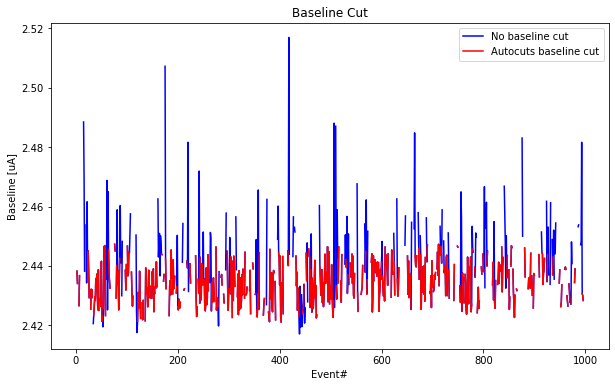

In [11]:
baseline_pre = diags['df']['baseline']
baseline_cut = diags['df']['baseline_cut']

# apply cut
baseline_post = np.empty(baseline_pre.shape)
baseline_post[:] = np.nan
baseline_post[baseline_cut] = baseline_pre[baseline_cut]

fig, ax = plt.subplots(figsize=(10, 6))
bins = np.asarray(list(range(baseline_pre.shape[-1])))
ax.plot(bins, baseline_pre*1e6, color='blue', label='No baseline cut')
ax.plot(bins, baseline_post*1e6, color='red', label='Autocuts baseline cut')

ax.set_title('Baseline Cut')
#ax.yaxis.tick_right()
plt.xlabel('Event#')
plt.ylabel('Baseline [uA]')
ax.legend()


## Using IterCut  directly for better cut control

A good way of understanding the cuts further than using the black box that is `autocuts` is to use the object-oriented version `IterCut`. This class allows the user freedom in cut order, which cuts are used, which algorithms are used for outlier removal, and more.

Below, we match the default parameters and outlier algorithm (`iterstat`) to show that the cut efficiency is the same.

In [12]:
# pulse template for OF algorithms (single rise/fall time)
nbins = traces.shape[-1]
t = np.arange(nbins) / fs
template = make_template(
    t,
    params=[1, 10e-6, 100e-6],
    fs=fs
)

# dummy psd
psd_dummy = np.ones(nbins)


# Instantiate IterCut
IC = IterCut(traces, fs)

# let's use sigma = 2 with default "sigma_clip"
cut_pars = {'sigma':2}
IC.baselinecut(cut_pars)
IC.slopecut(cut_pars)
IC.ofampscut(template, psd_dummy, cut_pars)
IC.ofchi2cut(template, psd_dummy, cut_pars)

# total cut
cut_ic = IC.cmask


print(f"The cut efficiency is {100*np.sum(cut_ic)/len(traces):.3f}%")


The cut efficiency is 28.600%


With `IterCut` we can also access the cuts at each step as they have been iteratively applied, and there is a lgc_plot option for plotting the passing event and failing events for each cut.

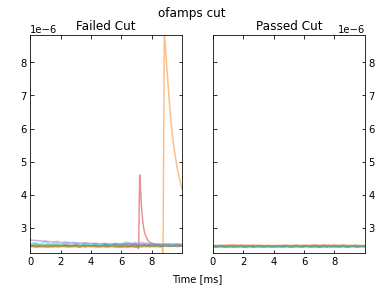

In [13]:
IC = IterCut(traces, fs)
cut_pars = {'sigma':2}
cofamps = IC.ofampscut(template, psd_dummy, cut_pars, lgc_plot=True)
cslope = IC.slopecut(cut_pars)
cbaseline = IC.baselinecut(cut_pars)
cofchi2 = IC.ofchi2cut(template, psd_dummy, cut_pars, 
                       nopulse_chi2=True)

# total cut
cut_ic = IC.cmask


This allows to calculate the efficiency of each cut, and we can see what cuts are going the heavy lifting. Note the importance of the denominator being the number of events that passed the previous cuts when calculating these efficiencies. If we were to divide by the number of traces each time, then this would be the total cut efficiency up to that cut. Below, we show the individual performance of each cut.

In [14]:
print(f"The  OF amp cut efficiency is {np.sum(cofamps)/len(traces):.3f}.")
print(f"The slope cut efficiency is {np.sum(cslope)/np.sum(cofamps):.3f}.")
print(f"The baseline cut efficiency is {np.sum(cbaseline)/np.sum(cslope):.3f}.")
print(f"The OF chi2 cut efficiency is {np.sum(cofchi2)/np.sum(cbaseline):.3f}.")
print("-------------")
print(f"The total cut efficiency is {np.sum(cut_ic)/len(traces):.3f}.")

The  OF amp cut efficiency is 0.474.
The slope cut efficiency is 0.772.
The baseline cut efficiency is 0.847.
The OF chi2 cut efficiency is 0.881.
-------------
The total cut efficiency is 0.273.


Thus, we see that the pileup cut is has the lowest efficiency, with the slope cut as a close second. If we were to remove the baseline and chi-squared cuts, then we would expect the PSD to not change noticeably. Let's test this expectation.

Note that we can also plot the events passing/failing a specific cut by passing `verbose=True`, as shown below.

In [15]:
IC = IterCut(traces, fs)
cut_pars = {'sigma':2}
cofamps = IC.ofampscut(template, psd_dummy, cut_pars)
cslope = IC.slopecut(cut_pars)

# total cut
cut_ic = IC.cmask

In [16]:
print(f"The OF amps cut efficiency is {np.sum(cofamps)/len(traces):.3f}.")
print(f"The slope cut efficiency is {np.sum(cslope)/np.sum(cofamps):.3f}.")
print("-------------")
print(f"The total cut efficiency is {np.sum(cut_ic)/len(traces):.3f}.")

The OF amps cut efficiency is 0.474.
The slope cut efficiency is 0.772.
-------------
The total cut efficiency is 0.366.


In [17]:
psd_cut = calc_psd(traces[cut_ic], fs=fs, folded_over=True)[1]

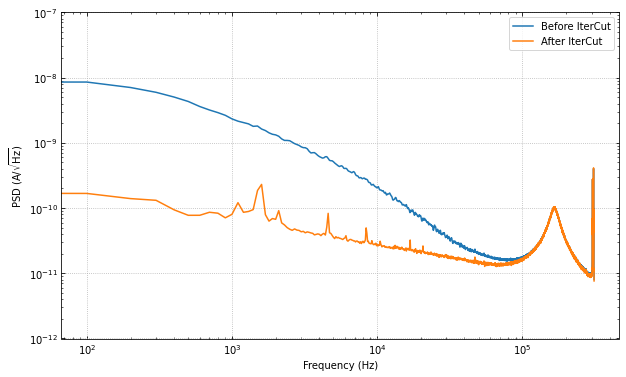

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(f, np.sqrt(psd), label="Before IterCut")
ax.loglog(f, np.sqrt(psd_cut), label="After IterCut")
ax.set_ylim([1e-12,1e-7])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'PSD (A/$\sqrt{\mathrm{Hz}}$)')
ax.legend(loc="upper right")
ax.grid(linestyle='dotted')
ax.tick_params(which='both',direction='in',right=True,top=True)

What if we reversed the cut order? How does this affect the cut efficiencies?

In [19]:
IC = IterCut(traces, fs)
cut_pars = {'sigma':2}
cofchi2 = IC.ofchi2cut(template, psd_dummy, cut_pars, 
                       nopulse_chi2=True)
cbaseline = IC.baselinecut(cut_pars)
cslope = IC.slopecut(cut_pars)
cofamps = IC.ofampscut(template, psd_dummy, cut_pars)
# total cut
cut_ic = IC.cmask


In [20]:
print(f"The OF chi2 cut efficiency is {np.sum(cofchi2)/len(traces):.3f}.")
print(f"The baseline cut efficiency is {np.sum(cbaseline)/np.sum(cofchi2):.3f}.")
print(f"The slope cut efficiency is {np.sum(cslope)/np.sum(cbaseline):.3f}.")
print(f"The OF amps cut efficiency is {np.sum(cofamps)/np.sum(cslope):.3f}.")
print("-------------")
print(f"The total cut efficiency is {np.sum(cut_ic)/len(traces):.3f}.")

The OF chi2 cut efficiency is 0.508.
The baseline cut efficiency is 0.870.
The slope cut efficiency is 0.767.
The OF amps cut efficiency is 0.714.
-------------
The total cut efficiency is 0.242.


In [21]:
psd_cut = calc_psd(traces[cut_ic], fs=fs, folded_over=True)[1]

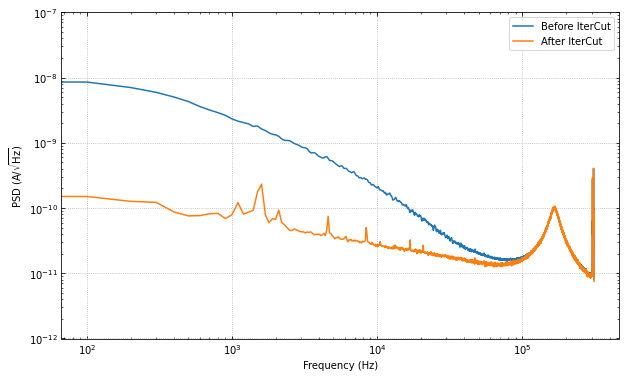

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(f, np.sqrt(psd), label="Before IterCut")
ax.loglog(f, np.sqrt(psd_cut), label="After IterCut")
ax.set_ylim([1e-12,1e-7])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel(r'PSD (A/$\sqrt{\mathrm{Hz}}$)')
ax.legend(loc="upper right")
ax.grid(linestyle='dotted')
ax.tick_params(which='both',direction='in',right=True,top=True)

The PSD is essentially the same, but the OF amps cut is no longer doing much, as we did it last (the previous three cuts ended cutting out a lot of pileup!). Thus, this shows that order does matter, and its worth thinking about what order makes the most sense in one's application.

## Advanced Usage: Arbitrary Cuts

For advanced users, `IterCut` includes an option to apply some arbitrary cut based on some function that isn't included by default (or some one-off user-defined function). As an example, let's add a maximum cut via `numpy.max`, but only finding the maximum up to some specified bin number in the trace.

In [23]:
maximum = lambda traces, end_index: np.max(traces[..., :end_index], axis=-1)

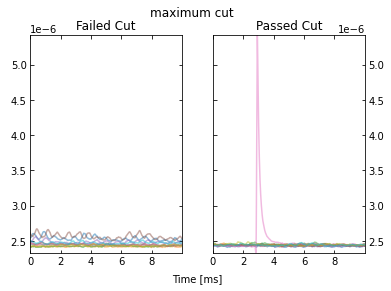

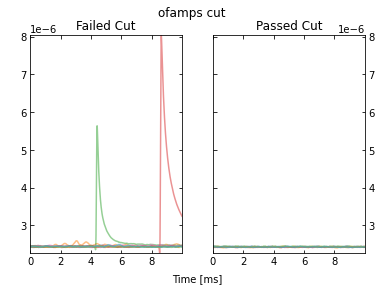

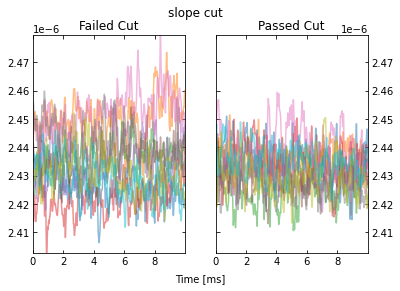

In [24]:
IC = IterCut(traces, fs, lgc_plot=True)
cut_pars = {'sigma':2}
cmaximum = IC.arbitrarycut(maximum, 200, cut_pars=cut_pars, cutname='maximum')
cofamps = IC.ofampscut(template, psd_dummy, cut_pars)
cslope = IC.slopecut(cut_pars )
cut_ic = IC.cmask

In [25]:
print(f"The maximum cut efficiency is {np.sum(cmaximum)/len(traces):.3f}.")
print(f"The OF amps cut efficiency is {np.sum(cofamps)/np.sum(cmaximum):.3f}.")
print(f"The slope cut efficiency is {np.sum(cslope)/np.sum(cofamps):.3f}.")
print("-------------")
print(f"The total cut efficiency is {np.sum(cut_ic)/len(traces):.3f}.")

The maximum cut efficiency is 0.695.
The OF amps cut efficiency is 0.578.
The slope cut efficiency is 0.843.
-------------
The total cut efficiency is 0.339.


Looking at the events that passed, we see that the maximum cut we applied allowed a "bad" trace (a trace with a pulse). This makes sense since we only looked at a portion of the trace for that cut, so it was not a very good cut. Fortunately, our pileup and slope cuts did a good job of removing the bad traces that passed the maximum cut.

Lastly, it's worth simply printing out the docstrings of the three different supported outlier algorithms. The `kwargs` vary considerably between each of them, so to specify them in `IterCut`, one must know which ones to use! For example, `iterstat` has the `cut` `kwarg`, which we were using in the above examples (because `iterstat` is the default outlier algorithm for these automated cut routines).

In [26]:
from qetpy.cut import iterstat, removeoutliers
from astropy.stats import sigma_clip

In [27]:
help(sigma_clip)

Help on function sigma_clip in module astropy.stats.sigma_clipping:

sigma_clip(data, sigma=3, sigma_lower=None, sigma_upper=None, maxiters=5, cenfunc='median', stdfunc='std', axis=None, masked=True, return_bounds=False, copy=True)
    Perform sigma-clipping on the provided data.
    
    The data will be iterated over, each time rejecting values that are
    less or more than a specified number of standard deviations from a
    center value.
    
    Clipped (rejected) pixels are those where::
    
        data < cenfunc(data [,axis=int]) - (sigma_lower * stdfunc(data [,axis=int]))
        data > cenfunc(data [,axis=int]) + (sigma_upper * stdfunc(data [,axis=int]))
    
    Invalid data values (i.e., NaN or inf) are automatically clipped.
    
    For an object-oriented interface to sigma clipping, see
    :class:`SigmaClip`.
    
    .. note::
        `scipy.stats.sigmaclip
        <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sigmaclip.html>`_
        provides a 

In [28]:
help(iterstat)

Help on function iterstat in module qetpy.cut._cut:

iterstat(data, sigma=2, precision=1000.0, return_unbiased_estimates=False)
    Function to iteratively remove outliers based on how many standard
    deviations they are from the mean, where the mean and standard
    deviation are recalculated after each cut.
    
    Parameters
    ----------
    data : ndarray
        Array of data that we want to remove outliers from.
    sigma : float, optional
        Number of standard deviations from the mean to be used for
        outlier rejection
    precision : float, optional
        Threshold for change in mean or standard deviation such that we
        stop iterating. The threshold is determined by
        np.std(data)/precision. This means that a higher number for
        precision means a lower threshold (i.e. more iterations).
    return_unbiased_estimates : bool, optional
        Boolean flag for whether or not to return the biased or
        unbiased estimates of the mean and stand

In [29]:
help(removeoutliers)

Help on function removeoutliers in module qetpy.cut._cut:

removeoutliers(x, maxiter=20, skewtarget=0.05)
    Function to return indices of inlying points, removing points
    by minimizing the skewness.
    
    Parameters
    ----------
    x : ndarray
        Array of real-valued variables from which to remove outliers.
    maxiter : float, optional
        Maximum number of iterations to continue to minimize skewness.
        Default is 20.
    skewtarget : float, optional
        Desired residual skewness of distribution. Default is 0.05.
    
    Returns
    -------
    inds : ndarray
        Boolean indices indicating which values to select/reject, same
        length as `x`.

